In [1]:
import os
import numpy as np
import SimpleITK as sitk
import nibabel as nib
from skimage import measure
from scipy.ndimage import label
import matplotlib.pyplot as plt
import glob
# from time import time
import time
import copy
import math
import argparse
import random
import warnings
import datetime
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision
# import ttach as tta

from dataset.dataset import Dataset
from net import Unet,res_unet_plus,R2Unet,sepnet,ResU_Net,liver_net
from net.swintransformer import swin_tiny_patch4_window7_224 as swintransformer
# MultiResUnet,dense_UNet,segnet,UNetplusplus,cbam_Unet
from utilities.utils import str2bool, count_params
import joblib
import imageio
from torchsummary import summary
#import ttach as tta

import cv2 as cv2

import PIL.Image as Image

/home/jouiry/miniconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dice_coef(output, target):
    smooth = 1e-5
    num = output.shape[0]
    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()

    input_1 = output[:,0,:,:]


    target_1 = target[:,0,:,:]


    intersection_1 = (input_1 * target_1)


    dice_1 = (2. * intersection_1.sum() + smooth) / (input_1.sum() + target_1.sum() + smooth)

    return dice_1

def predict(model, input, target):
    # image = input.swapaxes(0, 2)
    # img = torch.FloatTensor(input).cuda()
    img = input.cuda()
    img = img.unsqueeze(dim=0)
    target = target.unsqueeze(dim=0)
    output = model(img)
    dice_1 = dice_coef(output, target)

    
    output = torch.sigmoid(output).data.cpu().numpy()
    probability_map = np.zeros([1, output.shape[2], output.shape[3]], dtype=np.uint8)

    for idx in range(output.shape[2]):
        for idy in range(output.shape[3]):
            if (output[0,0, idx, idy] > 0.5):
                probability_map[0, idy, idx] = 1        
    
    return probability_map, dice_1

def plot(orginImage, originMask, pre1, pre2):
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
    ax[0].imshow(orginImage,cmap='gray')
    ax[1].imshow(originMask,cmap='gray')
    ax[2].imshow(pre1.swapaxes(0, 1),cmap='gray')
    ax[3].imshow(pre2.swapaxes(0, 1),cmap='gray')
    figure.tight_layout()
    figure.show()

def visualize_segmentation(image, segmentation_mask, ground_truth_mask):
    # 将分割掩码和真实标签转换为与颜色对应的标记
    tp_mask = (segmentation_mask == ground_truth_mask) & (ground_truth_mask == 1)
    fp_mask = (segmentation_mask == 1) & (ground_truth_mask == 0)
    fn_mask = (segmentation_mask == 0) & (ground_truth_mask == 1)

    # 创建一个可视化图像，其中TP为红色，FP为绿色，FN为蓝色
    visualized_image = np.copy(image)
    visualized_image[tp_mask] = (0, 0, 255)  # 红色
    visualized_image[fp_mask] = (0, 255, 0)  # 绿色
    visualized_image[fn_mask] = (255, 0, 0)  # 蓝色
    return visualized_image

Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))


/home/jouiry/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_1062/143364541.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


liver_dice:0.9545172764362804


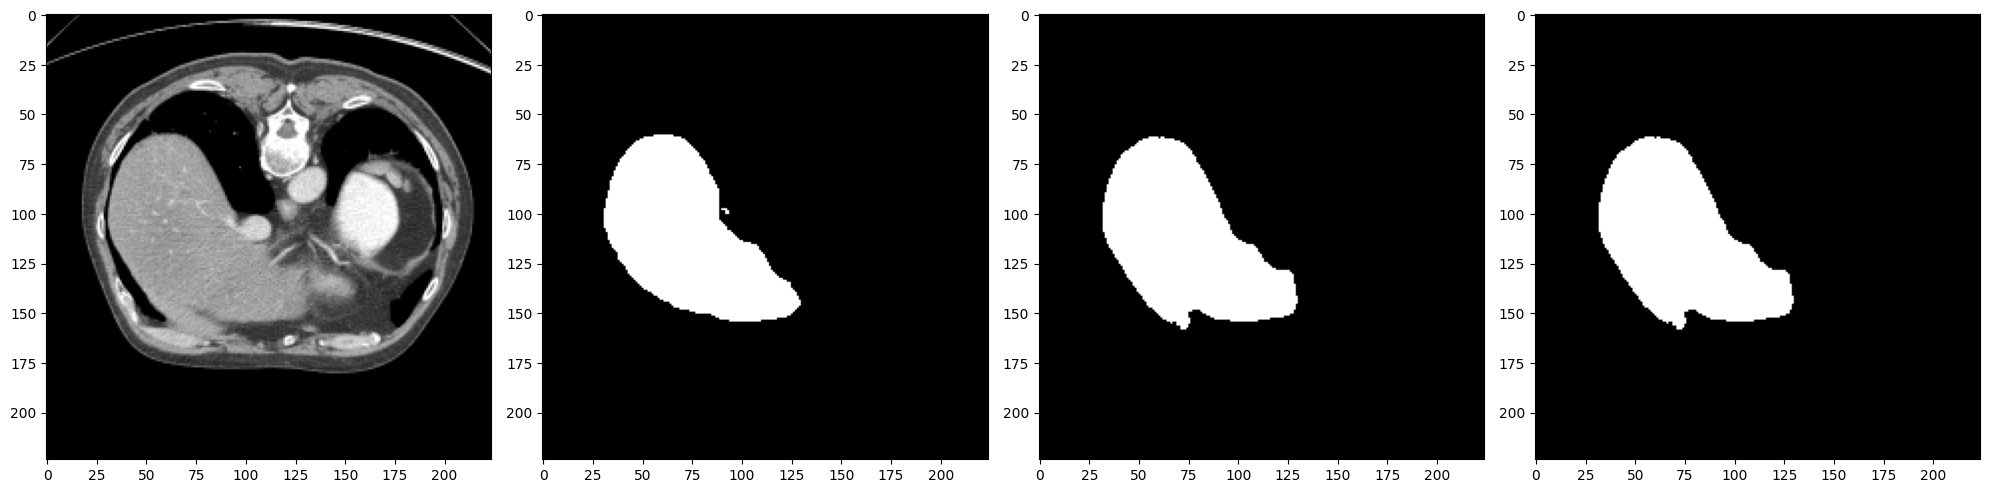

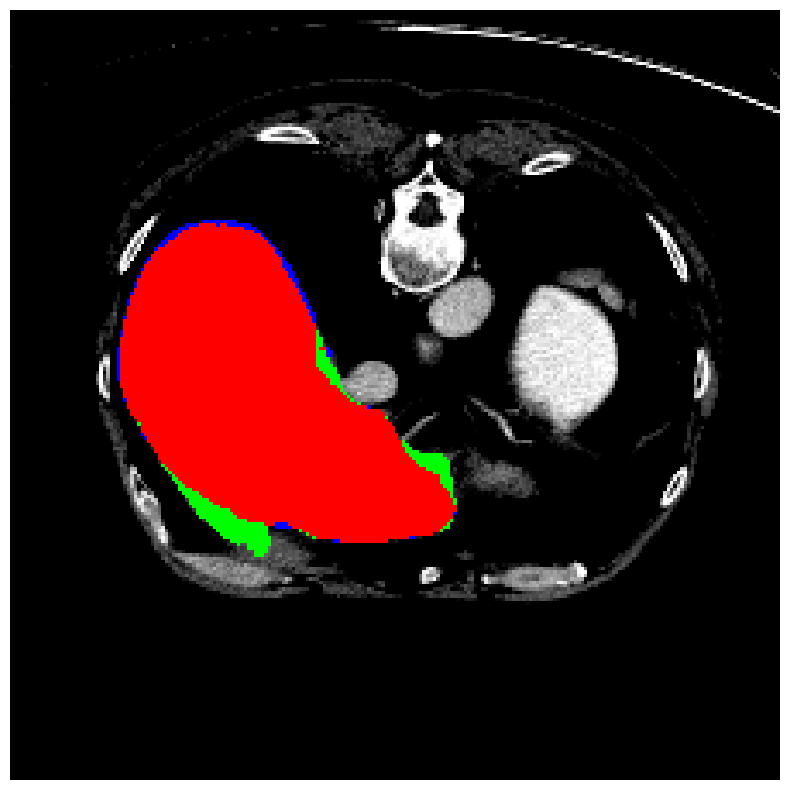

In [37]:
import os
import torch
import cv2 as cv2
from model.ResTransUNet import ResTransUNet_224 as ResTransUNet

model = ResTransUNet(0)
model = torch.nn.DataParallel(model).cuda()
print(model.module.Conv)

model.load_state_dict(torch.load('./weight/best.pth'))

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.features = None
        self.gradients = None

        self.model.module.Conv.register_forward_hook(self.save_features_hook)
        self.model.module.Conv.register_backward_hook(self.save_gradients_hook)

    def save_features_hook(self, module, input, output):
        self.features = output

    def save_gradients_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def calculate_cam(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        print(one_hot.shape)
        print(one_hot[0][0])
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        pooled_gradients = F.adaptive_avg_pool2d(self.gradients, 1)
        cam = torch.mul(self.features, pooled_gradients).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, input_tensor.size()[2:], mode="bilinear", align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = 1 - ((cam - cam.min()) / (cam.max() -cam.min()))
        return cam
    
ct_path = 'data/liver/validImage'   #需要预测的CT图像
mask_path = 'data/liver/validMask'
ct_files = os.listdir(ct_path)
mask_files = os.listdir(mask_path) 


n = 200
# 2 12 14 20 41
# 59 51



trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(224),
            ])




with warnings.catch_warnings():
    warnings.simplefilter('ignore')

# for i in range(len(ct_files)):
originImage = np.load(os.path.join(ct_path, ct_files[n]))



originMask = np.load(os.path.join(mask_path, mask_files[n]))

liver_label = originMask.copy()
liver_label[originMask == 2] = 1
liver_label[originMask == 1] = 1



nplabel = liver_label.astype("float32")
npimage = originImage.astype("float32")

npimage = trans(npimage)
nplabel = trans(nplabel)



# npimage = originImage.astype("float32")

# input_tensor = trans(npimage).unsqueeze(0).cuda()

pre, dice_1 = predict(model, npimage, nplabel)
print(f'liver_dice:{dice_1}')


# plt.imshow(pre.swapaxes(0, 2),cmap='gray')
# plt.axis('off')
# plt.savefig(jpg_path+ str(i) + '_' + str(j) +'.jpg')
# dst = Image.fromarray(pre.swapaxes(0,2).squeeze(2), 'P')
# bin_colormap = [0,0,0] + [150,0,0]+[0,255,0]+[0,0,0]*252  # 二值调色板
# dst.putpalette(bin_colormap)
# dst.save(jpg_path+ str(ct_files[i]) + '_' + str(j) +'.png')


image = cv2.resize(originImage, (224,224))

mask = cv2.resize(originMask, (224,224))
# print(pre1.shape)
pre = pre.squeeze(0)


plot(image, mask, pre, pre)
image = image*255
image[image>255] = 255
image[image<0] = 0
cv2.imwrite("yuantu.png", image)
image = cv2.imread("yuantu.png")
def visualize_segmentation(image, segmentation_mask, ground_truth_mask):
    # 将分割掩码和真实标签转换为与颜色对应的标记
    tp_mask = (segmentation_mask == ground_truth_mask) & (ground_truth_mask == 1)
    fp_mask = (segmentation_mask == 1) & (ground_truth_mask == 0)
    fn_mask = (segmentation_mask == 0) & (ground_truth_mask == 1)

    # 创建一个可视化图像，其中TP为红色，FP为绿色，FN为蓝色
    visualized_image = np.copy(image)
    visualized_image[tp_mask] = (255, 0, 0)  # 红色
    visualized_image[fp_mask] = (0, 255, 0)  # 绿色
    visualized_image[fn_mask] = (0, 0, 255)  # 蓝色

    # 显示可视化图像
    plt.figure(figsize=(10, 10))
    plt.imshow(visualized_image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    cv2.imwrite("res2.png", visualized_image)

# 假设我们有一些示例数据
# 这里我们使用随机数据作为示例
pre = pre.swapaxes(0, 1)

# 调用函数来可视化分割结果
visualize_segmentation(image, pre, mask)
# grad_cam = GradCAM(model)
# # 加载图像并预处理


# target_class = 0

# cam = grad_cam.calculate_cam(input_tensor, target_class)

# cam = np.uint8(255*cam)
# cam = np.uint8(cv2.resize(cam, (448, 448)))
# print(cam.shape)
# originImage = originImage.squeeze()
# print(originImage.shape)
# heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
# heatmap_pil = Image.fromarray(heatmap)
# image_pil = Image.fromarray(np.uint8(originImage))
# print(heatmap_pil)
# print(image_pil)



# if image_pil.mode == 'L':
#     image_pil = image_pil.convert('RGB')
# heatmap_pil = heatmap_pil.convert('L')
# result = Image.blend(image_pil, heatmap_pil, alpha=0.5)
# heatmap_pil.save("heatmap.jpg")
# plt.imshow(heatmap_pil)
# plt.axis('off')
# plt.show()
# cv2.imwrite('yuantu.jpg', originImage*255)